<h1>Data Preprocessing of Inflation Data</h1>

In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
import scipy.stats as sp

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [3]:
df = pd.read_csv('exploredData')

In [4]:
df.head()

,date,7 Day Bobc,1 Month BoBC,CHN,EUR,GBP,USD,SDR,YEN,ZAR,CPI,CPIT,CPIXA
0,2022-09-02,2.65,2.43,0.5340,0.0775,0.0670,0.0772,0.0595,10.84,1.3355,12.7,10.3,6.6
1,2022-09-01,2.65,2.43,0.5359,0.0774,0.0670,0.0775,0.0596,10.80,1.3333,12.7,10.3,6.6
2,2022-08-31,2.65,2.43,0.5395,0.0779,0.0669,0.0782,0.0599,10.82,1.3234,12.7,10.3,6.6
3,2022-08-30,2.15,2.43,0.5420,0.0783,0.0669,0.0783,0.0601,10.85,1.3191,12.7,10.3,6.6
4,2022-08-29,2.15,2.43,0.5405,0.0785,0.0669,0.0780,0.0600,10.83,1.3216,12.7,10.3,6.6


In [5]:
df['date'] = pd.to_datetime(df['date'])

In [6]:
df.set_index('date', inplace=True)

In [7]:
df.head()

,7 Day Bobc,1 Month BoBC,CHN,EUR,GBP,USD,SDR,YEN,ZAR,CPI,CPIT,CPIXA
date,,,,,,,,,,,,
2022-09-02,2.65,2.43,0.5340,0.0775,0.0670,0.0772,0.0595,10.84,1.3355,12.7,10.3,6.6
2022-09-01,2.65,2.43,0.5359,0.0774,0.0670,0.0775,0.0596,10.80,1.3333,12.7,10.3,6.6
2022-08-31,2.65,2.43,0.5395,0.0779,0.0669,0.0782,0.0599,10.82,1.3234,12.7,10.3,6.6
2022-08-30,2.15,2.43,0.5420,0.0783,0.0669,0.0783,0.0601,10.85,1.3191,12.7,10.3,6.6
2022-08-29,2.15,2.43,0.5405,0.0785,0.0669,0.0780,0.0600,10.83,1.3216,12.7,10.3,6.6


<AxesSubplot:xlabel='date'>

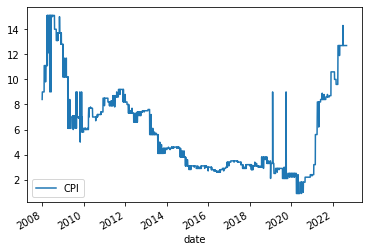

In [8]:
df[['CPI']].plot()

<h3>Feature Engineering</h3>

The dataset already has a low dimensionality and so there is no need for dimensionality reduction. Also, the data is consistent and heterogenous. There is no feature engineering that will be done on this dataset.

In addition, all features are continuous, so there is no need to create any dummy variables.

<h4>Breaking data into Training and Test sets</h4>

It is important to note that cpi, cpit, and cpixa are all measures of inflation rate even though cpi is the most common one. They will all be treated as target variables to see if the prediction model will be able to perform better predicting one of them than the others.

The data shall now be separated into test and training sets first before scaling to avoid scaling training data and testing data together. 

Also, linear model cannot handle DateTimeIndex objects, so the date column is to be converted to represent number of days from the 2nd September 2022.

In [9]:
# Converting date to number of days from September 2 2022.
df.index = (df.index[0] -  df.index).days

In [10]:
df

,7 Day Bobc,1 Month BoBC,CHN,EUR,GBP,USD,SDR,YEN,ZAR,CPI,CPIT,CPIXA
date,,,,,,,,,,,,
0,2.65,2.43,0.5340,0.077500,0.067000,0.077200,0.059500,10.8400,1.335500,12.7,10.3,6.6
1,2.65,2.43,0.5359,0.077400,0.067000,0.077500,0.059600,10.8000,1.333300,12.7,10.3,6.6
2,2.65,2.43,0.5395,0.077900,0.066900,0.078200,0.059900,10.8200,1.323400,12.7,10.3,6.6
3,2.15,2.43,0.5420,0.078300,0.066900,0.078300,0.060100,10.8500,1.319100,12.7,10.3,6.6
4,2.15,2.43,0.5405,0.078500,0.066900,0.078000,0.060000,10.8300,1.321600,12.7,10.3,6.6
...,...,...,...,...,...,...,...,...,...,...,...,...
5237,11.96,0.00,0.0000,0.100726,0.089723,0.140546,0.091038,13.1275,1.175903,12.1,11.0,9.1
5206,11.96,0.00,0.0000,0.100726,0.089723,0.140546,0.091038,13.1275,1.175903,14.5,12.5,9.8
5176,11.96,0.00,0.0000,0.100726,0.089723,0.140546,0.091038,13.1275,1.175903,15.0,12.7,11.1


In [11]:
# Resetting index so that the time series split function gives existing indexes
df.reset_index(inplace=True)

In [12]:
df

,date,7 Day Bobc,1 Month BoBC,CHN,EUR,GBP,USD,SDR,YEN,ZAR,CPI,CPIT,CPIXA
0,0,2.65,2.43,0.5340,0.077500,0.067000,0.077200,0.059500,10.8400,1.335500,12.7,10.3,6.6
1,1,2.65,2.43,0.5359,0.077400,0.067000,0.077500,0.059600,10.8000,1.333300,12.7,10.3,6.6
2,2,2.65,2.43,0.5395,0.077900,0.066900,0.078200,0.059900,10.8200,1.323400,12.7,10.3,6.6
3,3,2.15,2.43,0.5420,0.078300,0.066900,0.078300,0.060100,10.8500,1.319100,12.7,10.3,6.6
4,4,2.15,2.43,0.5405,0.078500,0.066900,0.078000,0.060000,10.8300,1.321600,12.7,10.3,6.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3766,5237,11.96,0.00,0.0000,0.100726,0.089723,0.140546,0.091038,13.1275,1.175903,12.1,11.0,9.1
3767,5206,11.96,0.00,0.0000,0.100726,0.089723,0.140546,0.091038,13.1275,1.175903,14.5,12.5,9.8
3768,5176,11.96,0.00,0.0000,0.100726,0.089723,0.140546,0.091038,13.1275,1.175903,15.0,12.7,11.1
3769,5298,11.96,0.00,0.0000,0.100726,0.089723,0.140546,0.091038,13.1275,1.175903,9.8,9.7,8.9


In [13]:
X = df
y = df['CPI']

In [14]:
tscv = TimeSeriesSplit()

In [15]:
# Split data into train and test, run linear regression model, and print R2 score, MSE, and MAE.
for train_index, test_index in tscv.split(y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
   
    
    lm = LinearRegression()
    lm.fit(X_train, y_train)
    
    ypred = lm.predict(X_test)
    
    
    print('R2 Score: ' + str(r2_score(y_test, ypred)))
    print('Mean Squared Error: ' + str(mean_squared_error(y_test, ypred)))
    print('Mean Absolute Error: ' + str(mean_absolute_error(y_test, ypred)))

TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244

The linear regression model was able to achieve an R_squared value of 1 without any hyperparameter tuning. Cross validation was used, and for each fold, the R2 value was one, while the MSE and MAE were virtually zero. The model seems to be performing quite well with the data. 

In [16]:
rm = Ridge()

In [17]:
for train_index, test_index in tscv.split(y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
   
    
    rm = Ridge()
    rm.fit(X_train, y_train)
    
    ypred = rm.predict(X_test)
    
    
    print('R2 Score: ' + str(r2_score(y_test, ypred)))
    print('Mean Squared Error: ' + str(mean_squared_error(y_test, ypred)))
    print('Mean Absolute Error: ' + str(mean_absolute_error(y_test, ypred)))

TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244

Metrics for Ridge Regression are similar though not as accurate as those for the Linear Regression Model.

In [18]:
for train_index, test_index in tscv.split(y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
   
    
    rm = Ridge()
    grid_search = GridSearchCV(rm, param_grid={'alpha':[0.001, 0.01, 0.1, 1, 10], 'solver':['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']},  cv=5)
    grid_search.fit(X_train, y_train)
    ypred = grid_search.predict(X_test)
    
    
    print('R2 Score: ' + str(r2_score(y_test, ypred)))
    print('Mean Squared Error: ' + str(mean_squared_error(y_test, ypred)))
    print('Mean Absolute Error: ' + str(mean_absolute_error(y_test, ypred)))

TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244

R2 Score: 0.9999999976087355
Mean Squared Error: 1.7062309902562465e-10
Mean Absolute Error: 9.534532098144033e-06
TRAIN: [   0    1    2 ... 1884 1885 1886] TEST: [1887 1888 1889 1890 1891 1892 1893 1894 1895 1896 1897 1898 1899 1900
 1901 1902 1903 1904 1905 1906 1907 1908 1909 1910 1911 1912 1913 1914
 1915 1916 1917 1918 1919 1920 1921 1922 1923 1924 1925 1926 1927 1928
 1929 1930 1931 1932 1933 1934 1935 1936 1937 1938 1939 1940 1941 1942
 1943 1944 1945 1946 1947 1948 1949 1950 1951 1952 1953 1954 1955 1956
 1957 1958 1959 1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970
 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984
 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998
 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012
 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024 2025 2026
 2027 2028 2029 2030 2031 2032 2033 2034 2035 2036 2037 2038 2039 2040
 2041 2042 2043 2044 2045 2046 2047 2048 2049 2050 2051

R2 Score: 0.9999999999989274
Mean Squared Error: 1.565716265988692e-11
Mean Absolute Error: 3.0779162335550058e-06


Hyper parameter tuning makes Ridge Regression model slightly more accurate, though it's quite negligible.

In [19]:
df.to_csv('PreprocessedData')